In [2]:
from sklearn.manifold import TSNE
from keras.datasets import mnist
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd  
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Raw data [tutorial](https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html)

(3000, 28, 28)
(3000, 784)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.052s...
[t-SNE] Computed neighbors for 3000 samples in 11.060s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 480.474473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.812782
[t-SNE] Error after 1000 iterations: 1.264216


[Text(0.5, 1.0, 'MNIST data T-SNE projection')]

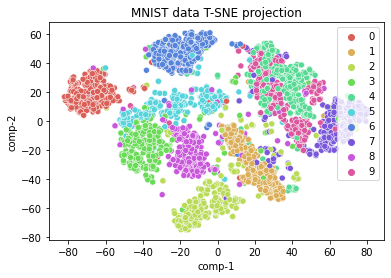

In [3]:
(x_train, y_train), (_ , _) = mnist.load_data()
x_train = x_train[:3000]
y_train = y_train[:3000]
print(x_train.shape) 
 
x_mnist = reshape(x_train, [x_train.shape[0], x_train.shape[1]*x_train.shape[2]])
print(x_mnist.shape)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_mnist)
 
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="MNIST data T-SNE projection")

### Save features of the model

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

init_lr = 1e-3
batch_size = 64
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)
x_train, x_test = x_train / 255.0, x_test / 255.0
print('raw x_train:', x_train.shape)

# # Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)
print('train_ds:', train_ds._input_dataset)
print('x_train:', x_train.mean(), x_train.max(), x_train.min())

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = Sequential()
        self.model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
        self.model.add(MaxPool2D(strides=2))
        self.model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
        self.model.add(MaxPool2D(strides=2))
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Dense(84, activation='relu'))
        self.classifier = Dense(10, activation=None)

    def call(self, x):
        x = self.model(x)
        return self.classifier(x), x

def get_cross_entropy_loss(labels, logits):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels,
                                                   logits=logits)
    return tf.reduce_mean(loss)

@tf.function
def test_step(images, labels):
    logits, _ = model(images, training=False)
    test_acc(tf.nn.softmax(logits), labels)

@tf.function
def train_step(src_images, src_labels):
    with tf.GradientTape() as tape:
        src_logits, _ = model(src_images, training=True)
        batch_cross_entropy_loss = get_cross_entropy_loss(labels=src_labels,
                                                          logits=src_logits)

    gradients = tape.gradient(batch_cross_entropy_loss,
                              model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    source_train_acc(src_labels, tf.nn.softmax(src_logits))


learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
    init_lr,
    decay_steps=(x_train.shape[0] // batch_size) * 2,
    end_learning_rate=init_lr * 1e-2,
    cycle=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
test_acc = tf.keras.metrics.CategoricalAccuracy()
source_train_acc = tf.keras.metrics.CategoricalAccuracy()
model = MyModel()

for epoch in range(1):
    for images, labels in train_ds:
        train_step(images, labels)
    for images, labels in test_ds:
        test_step(images, labels)
    print('epoch:',epoch, 'train:', source_train_acc.result().numpy(), 'test:', test_acc.result().numpy())

raw x_train: (60000, 28, 28)
train_ds: <ShuffleDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>
x_train: 0.13066062 1.0 0.0
epoch: 0 train: 0.95608336 test: 0.9878


##### Train

In [6]:
features = None
labels = None
for images, _labels in train_ds:
    _, feature = model(images, training=False)
    if features is None:
        features = feature
        labels = _labels
    else:
        features = tf.concat((features, feature), axis=0)
        labels = tf.concat((labels, _labels), axis=0)

In [9]:
x = features[:200]
y = labels[:200]
y = tf.argmax(y, axis=1)

##### t-sne 
to set style see [here](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

In [10]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)
 
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df["domain"] = np.concatenate((np.repeat('source', 100), 
                               np.repeat('target', 100)))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 8.016043
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.772964
[t-SNE] Error after 1000 iterations: 0.187966


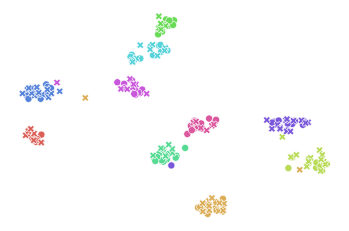

In [11]:
sns.set_theme(style="white", color_codes=True)
p1 = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 10),
                    style="domain",
                    markers = {"source": "o", "target": "X"},
                    s=50,
                    legend = False,
                    data=df)
# p1.set(title="MNIST data T-SNE projection")
p1.set(xlabel=None)
p1.set(ylabel=None)
p1.set(xticklabels=[])
p1.set(yticklabels=[])
sns.despine(top=True, right=True, left=True, bottom=True)

In [ ]:
plt.savefig('deletme.png')

<Figure size 432x288 with 0 Axes>